Step 1: Data Extraction (using requests, retry, logging)

In [14]:
import requests
import time
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def fetch_fuel_price_data(url, retries=3, delay=2):
    for attempt in range(1, retries + 1):
        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()
            logging.info(f"Success on attempt {attempt}")
            return response.json()
        except requests.exceptions.RequestException as e:
            logging.error(f"Attempt {attempt} failed: {e}")
            if attempt < retries:
                time.sleep(delay)
            else:
                logging.critical("All retries failed.")
                return None

url = "https://api.data.gov.my/data-catalogue?id=fuelprice"
data = fetch_fuel_price_data(url)

# Display a sample of the data
import json
print(json.dumps(data[:2], indent=2))  # Print first 2 entries for inspection


2025-05-06 17:47:39,395 - INFO - Success on attempt 1


[
  {
    "date": "2025-05-01",
    "ron95": 2.05,
    "ron97": 3.18,
    "diesel": 2.88,
    "series_type": "level",
    "diesel_eastmsia": 2.15
  },
  {
    "date": "2025-04-24",
    "ron95": 2.05,
    "ron97": 3.18,
    "diesel": 2.88,
    "series_type": "level",
    "diesel_eastmsia": 2.15
  }
]


Step 2: Data Transformation

In [15]:
import pandas as pd

# Example JSON data (you likely loaded this from a file or API)
data = [
    {
        "date": "2025-05-01",
        "ron95": 2.05,
        "ron97": 3.18,
        "diesel": 2.88,
        "series_type": "level",
        "diesel_eastmsia": 2.15
    },
    {
        "date": "2025-04-24",
        "ron95": 2.05,
        "ron97": 3.18,
        "diesel": 2.88,
        "series_type": "level",
        "diesel_eastmsia": 2.15
    },
    # ... more records ...
]

# Load data into DataFrame
df = pd.DataFrame(data)

# Convert column names to lowercase and strip any extra whitespace
df.columns = df.columns.str.strip().str.lower()

# Rename columns to desired format
df = df.rename(columns={
    'ron95': 'RON95_price',
    'ron97': 'RON97_price',
    'diesel': 'Diesel_price',
    'date': 'Date'
})

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort by Date
df = df.sort_values('Date')

# Calculate weekly price differences
df['RON95_price_diff'] = df['RON95_price'].diff()
df['RON97_price_diff'] = df['RON97_price'].diff()

# 4-week rolling average
df['RON95_4week_avg'] = df['RON95_price'].rolling(window=4).mean()

# View result
print(df.head())


        Date  RON95_price  RON97_price  Diesel_price series_type  \
1 2025-04-24         2.05         3.18          2.88       level   
0 2025-05-01         2.05         3.18          2.88       level   

   diesel_eastmsia  RON95_price_diff  RON97_price_diff  RON95_4week_avg  
1             2.15               NaN               NaN              NaN  
0             2.15               0.0               0.0              NaN  


Step 3: Insight Generation and Visualization

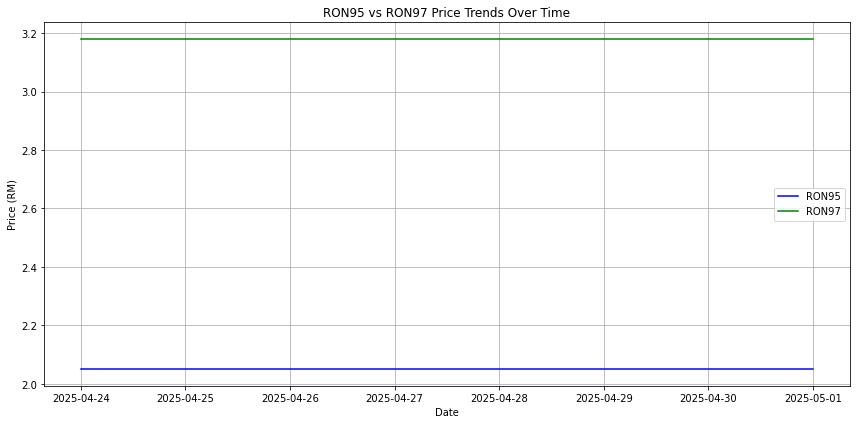

Week with the largest jump in RON95 price:
         Date  RON95_price_diff  RON97_price_diff
0 2025-05-01               0.0               0.0


In [16]:
import matplotlib.pyplot as plt

# RON95 vs RON97 Over Time
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['RON95_price'], label='RON95', color='blue')
plt.plot(df['Date'], df['RON97_price'], label='RON97', color='green')
plt.title("RON95 vs RON97 Price Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Price (RM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Largest jump in RON95 price
largest_jump = df[['Date', 'RON95_price_diff', 'RON97_price_diff']].sort_values(
    by='RON95_price_diff', ascending=False).head(1)
print("Week with the largest jump in RON95 price:\n", largest_jump)
